# NeuralODE

I made this notebook and the accompanying scripts to better understand NeuralODEs.


**Moritz Laber** (last update:2024/03/01)

In [1]:
# import libraries
import jax
import jax.numpy as jnp
import jax.random as jr
from jax.typing import ArrayLike
import equinox as eqx
import optax as tx
import diffrax as dfx
import numpy as np
from typing import List, Tuple, Callable
from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons

plt.style.use('default')

In [2]:
# import custom code
from models import *
from data_handlers import *
from trainers import *

## NeuralODE for Dynamics

### Preparation

In [3]:
### PARAMETERS ###

dims = [2, 64, 2]           # MLP layer dimensions

n_trajectories = 32         # number of trajectories
n_points = 1000             # length of trajectories
t_max = 10                  # maximum real time
batch_size = 16             # size of each batch

schedule = [(100, (0,50), 0.003),       # steps, (tmin,tmax), learning_rate
            (1000, (10, 490), 0.001)]   # steps, (tmin,tmax), learning_rate

seed = 1729             # seed for pseudo-random number generation.

In [4]:
# key for PRNG
key = jr.PRNGKey(seed)

# split the key
data_key, params_key, shuffle_key = jr.split(key, 3)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


### Computation

In [5]:
# generate the dataset
ts, ys = generate_trajectories(n_trajectories=n_trajectories,   # number of trajectories
                               n_points=n_points,               # number of points on trajectory
                               tmax=t_max,                      # maximum real time
                               key=data_key)                    # prng key             

In [6]:
# initialize the neural ode in train it
nde = NeuralODE(dims, key=params_key)

# train the neural ode
nde, loss_list = trajectory_train(
            nde,                      # model
            (ts, ys),                 # dataset
            schedule,                 # training schedule
            batch_size,               # batch_size
            key=shuffle_key           # PRNGkey
            )

100it [00:07, 14.10it/s]
1000it [00:10, 96.93it/s]


### Evaluation

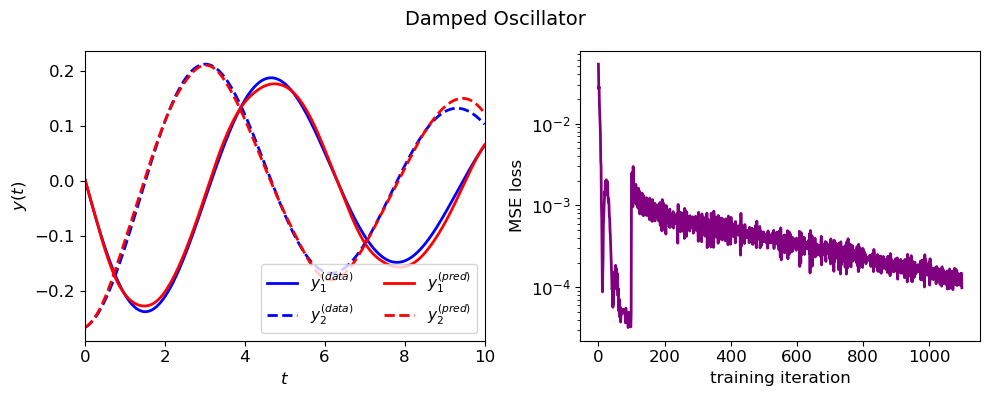

In [7]:
## plot the result on the training data

# select trajectory
idx = 12

# make prediction
ypred = nde(ts,ys[idx,0,:])

# generate plot
fig = plt.figure(figsize=(10,4))

fig.suptitle(r'Damped Oscillator', fontsize=14)

ax1 = fig.add_subplot(121)

ax1.plot(ts,ys[idx,:,0], c='b', ls='-', lw=2)   # data
ax1.plot(ts,ys[idx,:,1], c='b', ls='--', lw=2)

ax1.plot(ts,ypred[:, 0], c='r', ls='-', lw=2)    # prediction
ax1.plot(ts,ypred[:, 1], c='r', ls='--', lw=2)
ax1.legend([r'$y_1^{(data)}$',r'$y_2^{(data)}$', r'$y_1^{(pred)}$', r'$y_2^{(pred)}$'], fontsize=11, ncol=2, loc='lower right')
ax1.set_xlim(0, t_max)
ax1.tick_params(labelsize=12)
ax1.set_ylabel(r'$y(t)$', fontsize=12)
ax1.set_xlabel(r'$t$', fontsize=12)


ax2 = fig.add_subplot(122)

ax2.semilogy(loss_list, c='purple', ls='-', lw=2)

ax2.set_xlabel('training iteration', fontsize=12)
ax2.set_ylabel('MSE loss', fontsize=12)
ax2.tick_params(labelsize=12)

fig.tight_layout()

## NeuralODE for Classification 

### Preparation

In [8]:
## PARAMETERS 

dims = [2, 64, 2]           # MLP layer dimensions

n_samples = 512     # number of samples in the moons dataset
noise = 0.1         # standard deviation of noise on half-moons

tmin = 0.   # arbitrary start time
tmax = 1.   # arbitrary stop time

schedule = [(2000, 0.006),   # steps  learning rate
            (2000, 0.003)]   # steps, learning rate

batch_size = 32

seed = 1729         # seed for all following prngs

In [9]:
# set key for jax
key = jr.PRNGKey(seed=seed)

# split the key
params_key, shuffle_key = jr.split(key, 2)

# prepare numpy random state
rng = np.random.RandomState(seed=seed)

### Computation

In [10]:
# generate a dataset
points, labels = make_moons(n_samples=n_samples, noise=noise, random_state=rng)

# choose arbitrary time interval
ts = jnp.array([tmin, tmax])

In [11]:
# initialize the neural ode in train it
nde = NeuralODE(dims, key=params_key)

# train the neural ode
nde, loss_list = classifier_train(
            nde,                      # model
            (ts, points, labels),     # dataset
            schedule,                 # training schedule
            batch_size,               # batch_size
            key=shuffle_key           # PRNGkey
            )

2000it [00:15, 127.14it/s]
2000it [00:09, 217.09it/s]


### Evaluation

In [12]:
def classifier_eval(model:eqx.Module, ts:ArrayLike, points:ArrayLike) -> Tuple[ArrayLike]:
    """Evaluate the NeuralODE at given time points starting from specific initial
       condition and calculate the probabilities of class membership along the 
       trajectories.

    Input
    model - a NeuralODE model
    ts - the time points at which to evaluate the NeuralODE
    points - the initial conditiosn   
       
    Output
    ypred - the trajectories starting at the initial condition
    probs - the probabilities of class membership at each time point
    """

    # calculate the trajectories
    ypred = jax.vmap(model, in_axes=(None,0))(ts, points)

    # calculate the probability of class membership along the trajectory
    probs = jax.nn.sigmoid(ypred[:, :, -1])
    
    return ypred, probs

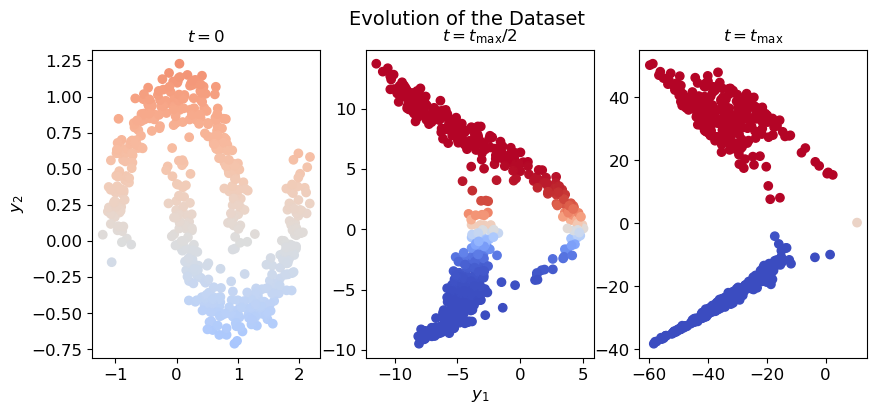

In [13]:
# PLOT THE RESULT (ON TRAINING DATA)

# select the timestep
t = -1                  # index of time point at which to evaluate
n_eval = 100            # number of time points to evaluate at
colormap = 'coolwarm'   # colormap

# make prediction
ypred, probs = classifier_eval(nde, jnp.linspace(tmin, tmax, n_eval), points)

# get the colormap
cmap = mpl.colormaps[colormap]

# generate plot
fig = plt.figure(figsize=(10,4))
fig.suptitle(r'Evolution of the Dataset', fontsize=14)

ax1 = fig.add_subplot(131)
ax1.set_title(r'$t = 0$', fontsize=12)
ax1.scatter(ypred[:, 0, 0], ypred[:, 0, 1], marker='o', color=cmap(probs[:, 0]))

ax1.set_ylabel(r'$y_2$', fontsize=12)
ax1.tick_params(labelsize=12)


ax2 = fig.add_subplot(132)
ax2.set_title(r'$t = t_\mathrm{max}/2$', fontsize=12)
ax2.scatter(ypred[:, n_eval//2, 0], ypred[:, n_eval//2, 1], marker='o', color=cmap(probs[:,n_eval//2]))

ax2.set_xlabel(r'$y_1$', fontsize=12)
ax2.tick_params(labelsize=12)


ax3 = fig.add_subplot(133)
ax3.set_title(r'$t=t_\mathrm{max}$', fontsize=12)
ax3.scatter(ypred[:, -1, 0], ypred[:, -1, 1], marker='o', color=cmap(probs[:,n_eval]))
ax3.tick_params(labelsize=12)

#TODO: colorbar

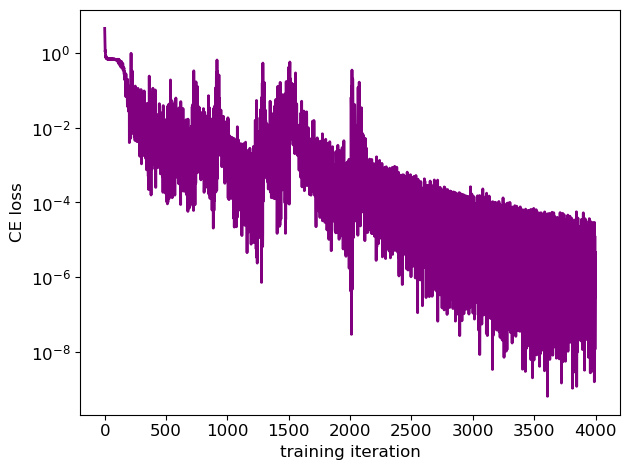

In [14]:
# Plot the Loss

fig = plt.figure()

ax = fig.add_subplot(111)
ax.semilogy(loss_list, ls='-', lw=2, color='purple')
ax.set_xlabel(r'training iteration', fontsize=12)
ax.set_ylabel(r'CE loss', fontsize=12)
ax.tick_params(labelsize=12)

fig.tight_layout()